<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 39, '日付': '2021-12-24T08:00:00.000Z'},
 {'小計': 38, '日付': '2021-12-25T08:00:00.000Z'},
 {'小計': 43, '日付': '2021-12-26T08:00:00.000Z'},
 {'小計': 35, '日付': '2021-12-27T08:00:00.000Z'},
 {'小計': 46, '日付': '2021-12-28T08:00:00.000Z'},
 {'小計': 76, '日付': '2021-12-29T08:00:00.000Z'},
 {'小計': 64, '日付': '2021-12-30T08:00:00.000Z'},
 {'小計': 78, '日付': '2021-12-31T08:00:00.000Z'},
 {'小計': 79, '日付': '2022-01-01T08:00:00.000Z'},
 {'小計': 84, '日付': '2022-01-02T08:00:00.000Z'},
 {'小計': 103, '日付': '2022-01-03T08:00:00.000Z'},
 {'小計': 151, '日付': '2022-01-04T08:00:00.000Z'},
 {'小計': 390, '日付': '2022-01-05T08:00:00.000Z'},
 {'小計': 641, '日付': '2022-01-06T08:00:00.000Z'},
 {'小計': 922, '日付': '2022-01-07T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-01-03 17:00:00+09:00,180,0,103,2022-01-03 17:00:00+09:00
2022-01-04 17:00:00+09:00,269,0,151,2022-01-04 17:00:00+09:00
2022-01-05 17:00:00+09:00,328,0,390,2022-01-05 17:00:00+09:00
2022-01-06 17:00:00+09:00,357,0,641,2022-01-06 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-01-03 17:00:00+09:00,180,0,103,2022-01-03 17:00:00+09:00,173.142857,1212.0,0.0,0.0,75.714286,530.0
2022-01-04 17:00:00+09:00,269,0,151,2022-01-04 17:00:00+09:00,192.714286,1349.0,0.0,0.0,90.714286,635.0
2022-01-05 17:00:00+09:00,328,0,390,2022-01-05 17:00:00+09:00,206.571429,1446.0,0.0,0.0,135.571429,949.0
2022-01-06 17:00:00+09:00,357,0,641,2022-01-06 17:00:00+09:00,223.857143,1567.0,0.0,0.0,218.000000,1526.0
2022-01-07 17:00:00+09:00,0,0,922,2022-01-07 17:00:00+09:00,201.428571,1410.0,0.0,0.0,338.571429,2370.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-12-24 17:00:00+09:00,168,0,39,2021-12-24 17:00:00+09:00,125.428571,878.0,0.0,0.0,32.285714,226.0,'21w51,Fri
2021-12-25 17:00:00+09:00,188,0,38,2021-12-25 17:00:00+09:00,136.714286,957.0,0.0,0.0,33.714286,236.0,'21w51,Sat
2021-12-26 17:00:00+09:00,119,0,43,2021-12-26 17:00:00+09:00,138.571429,970.0,0.0,0.0,35.142857,246.0,'21w51,Sun
2021-12-27 17:00:00+09:00,164,0,35,2021-12-27 17:00:00+09:00,144.285714,1010.0,0.0,0.0,38.571429,270.0,'21w52,Mon
2021-12-28 17:00:00+09:00,132,0,46,2021-12-28 17:00:00+09:00,147.000000,1029.0,0.0,0.0,39.714286,278.0,'21w52,Tue
2021-12-29 17:00:00+09:00,231,0,76,2021-12-29 17:00:00+09:00,162.571429,1138.0,0.0,0.0,44.857143,314.0,'21w52,Wed
2021-12-30 17:00:00+09:00,236,0,64,2021-12-30 17:00:00+09:00,176.857143,1238.0,0.0,0.0,48.714286,341.0,'21w52,Thu
2021-12-31 17:00:00+09:00,157,0,78,2021-12-31 17:00:00+09:00,175.285714,1227.0,0.0,0.0,54.285714,380.0,'21w52,Fri
2022-01-01 17:00:00+09:00,131,0,79,2022-01-01 17:00:00+09:00,167.142857,1170.0,0.0,0.0,60.142857,421.0,'22w52,Sat
2022-01-02 17:00:00+09:00,145,0,84,2022-01-02 17:00:00+09:00,170.857143,1196.0,0.0,0.0,66.000000,462.0,'22w52,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-12-26 17:00:00+09:00,35.142857,246
2021-12-31 17:00:00+09:00,59.800000,299
2021-01-03 17:00:00+09:00,816.000000,2448
2022-01-07 17:00:00+09:00,441.400000,2207
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-12-24 17:00:00+09:00,168,0,39,2021-12-24 17:00:00+09:00,125.428571,878.0,0.0,0.0,32.285714,226.0,'21w51,Fri,NaN,NaN
2021-12-25 17:00:00+09:00,188,0,38,2021-12-25 17:00:00+09:00,136.714286,957.0,0.0,0.0,33.714286,236.0,'21w51,Sat,NaN,NaN
2021-12-26 17:00:00+09:00,119,0,43,2021-12-26 17:00:00+09:00,138.571429,970.0,0.0,0.0,35.142857,246.0,'21w51,Sun,35.142857,246.0
2021-12-27 17:00:00+09:00,164,0,35,2021-12-27 17:00:00+09:00,144.285714,1010.0,0.0,0.0,38.571429,270.0,'21w52,Mon,NaN,NaN
2021-12-28 17:00:00+09:00,132,0,46,2021-12-28 17:00:00+09:00,147.000000,1029.0,0.0,0.0,39.714286,278.0,'21w52,Tue,NaN,NaN
2021-12-29 17:00:00+09:00,231,0,76,2021-12-29 17:00:00+09:00,162.571429,1138.0,0.0,0.0,44.857143,314.0,'21w52,Wed,NaN,NaN
2021-12-30 17:00:00+09:00,236,0,64,2021-12-30 17:00:00+09:00,176.857143,1238.0,0.0,0.0,48.714286,341.0,'21w52,Thu,NaN,NaN
2021-12-31 17:00:00+09:00,157,0,78,2021-12-31 17:00:00+09:00,175.285714,1227.0,0.0,0.0,54.285714,380.0,'21w52,Fri,59.800000,299.0
2022-01-01 17:00:00+09:00,131,0,79,2022-01-01 17:00:00+09:00,167.142857,1170.0,0.0,0.0,60.142857,421.0,'22w52,Sat,NaN,NaN
2022-01-02 17:00:00+09:00,145,0,84,2022-01-02 17:00:00+09:00,170.857143,1196.0,0.0,0.0,66.000000,462.0,'22w52,Sun,81.500000,163.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

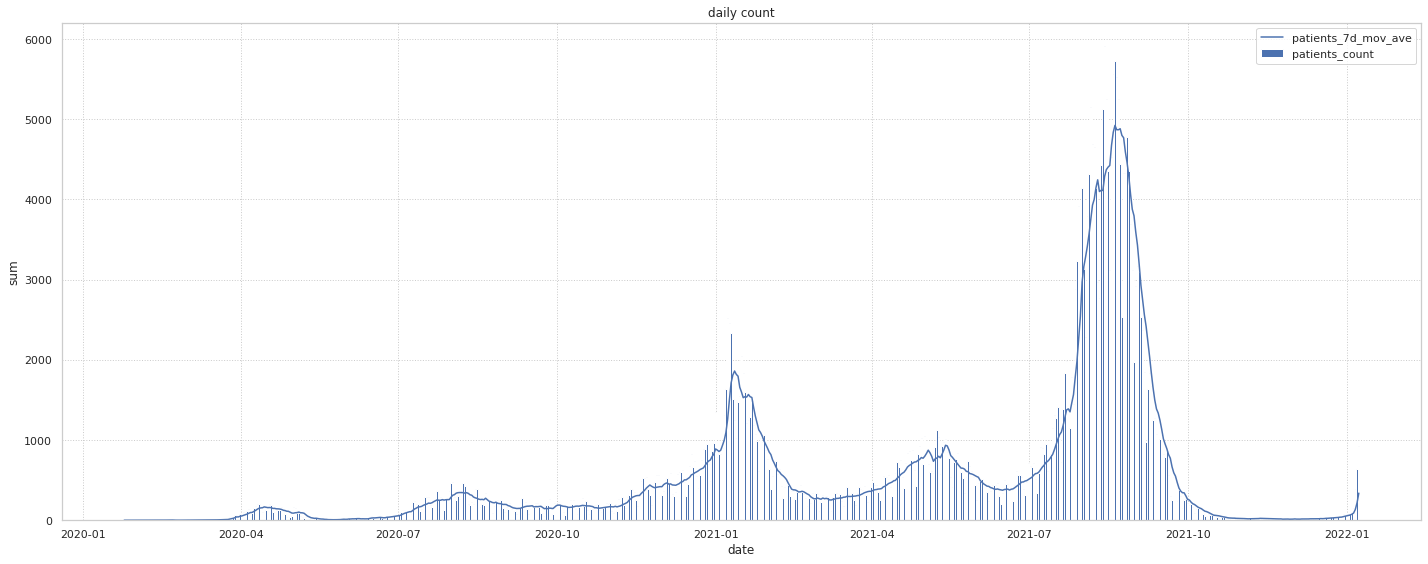

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
700,1.640333e+09,2021,12,24,1,0,0,0,0,0,0,700,0,626,168,125.428571,878.0,0,0.0,0.0,39,32.285714,226.0
701,1.640419e+09,2021,12,25,0,0,1,0,0,0,0,701,0,627,188,136.714286,957.0,0,0.0,0.0,38,33.714286,236.0
702,1.640506e+09,2021,12,26,0,0,0,1,0,0,0,702,0,628,119,138.571429,970.0,0,0.0,0.0,43,35.142857,246.0
703,1.640592e+09,2021,12,27,0,1,0,0,0,0,0,703,0,629,164,144.285714,1010.0,0,0.0,0.0,35,38.571429,270.0
704,1.640678e+09,2021,12,28,0,0,0,0,0,1,0,704,0,630,132,147.000000,1029.0,0,0.0,0.0,46,39.714286,278.0
705,1.640765e+09,2021,12,29,0,0,0,0,0,0,1,705,0,631,231,162.571429,1138.0,0,0.0,0.0,76,44.857143,314.0
706,1.640851e+09,2021,12,30,0,0,0,0,1,0,0,706,0,632,236,176.857143,1238.0,0,0.0,0.0,64,48.714286,341.0
707,1.640938e+09,2021,12,31,1,0,0,0,0,0,0,707,0,633,157,175.285714,1227.0,0,0.0,0.0,78,54.285714,380.0
708,1.641024e+09,2022,1,1,0,0,1,0,0,0,0,708,0,634,131,167.142857,1170.0,0,0.0,0.0,79,60.142857,421.0
709,1.641110e+09,2022,1,2,0,0,0,1,0,0,0,709,0,635,145,170.857143,1196.0,0,0.0,0.0,84,66.000000,462.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            715 non-null    float64
 1   year                 715 non-null    int64  
 2   month                715 non-null    int64  
 3   day                  715 non-null    int64  
 4   Fri                  715 non-null    uint8  
 5   Mon                  715 non-null    uint8  
 6   Sat                  715 non-null    uint8  
 7   Sun                  715 non-null    uint8  
 8   Thu                  715 non-null    uint8  
 9   Tue                  715 non-null    uint8  
 10  Wed                  715 non-null    uint8  
 11  passed               715 non-null    int64  
 12  emergency            715 non-null    int64  
 13  em_passed            715 non-null    int64  
 14  contacts_count       715 non-null    int64  
 15  contacts_7d_mov_ave  715 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.150000e+02,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,1.610698e+09,2020.530070,6.643357,15.744056,0.144056,0.142657,0.142657,0.142657,0.142657,0.142657,0.142657,357.000000,0.068531,286.881119,612.910490,612.030336,4284.206993,515.411189,515.411189,3607.878322,539.088112,536.885574,3758.176224
std,1.784566e+07,0.518703,3.388904,8.881271,0.351392,0.349968,0.349968,0.349968,0.349968,0.349968,0.349968,206.547008,0.252833,200.633398,475.013242,464.535611,3251.756312,802.347193,734.879299,5144.155093,950.331904,919.387106,6435.723057
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595275e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.500000,0.000000,104.500000,309.500000,298.428571,2089.000000,0.000000,0.000000,0.000000,40.000000,40.571429,284.000000
50%,1.610698e+09,2021.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,357.000000,0.000000,283.000000,489.000000,484.285714,3390.000000,0.000000,0.000000,0.000000,234.000000,238.142857,1667.000000
75%,1.626120e+09,2021.000000,10.000000,23.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,535.500000,0.000000,461.500000,753.000000,738.285714,5168.000000,1066.000000,1071.857143,7503.000000,555.000000,556.500000,3895.500000
max,1.641542e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,714.000000,1.000000,640.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5908.000000,4923.428571,34464.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.866404,0.411043,-0.001128,5.824184e-18,-0.000988,-0.004941,-0.002964,0.004941,0.000988,0.002964,1.000000e+00,-0.340366,0.998275,-0.321955,-0.313334,-0.313331,-0.616052,-0.662409,-0.662409,0.329462,0.344885,0.344890
year,8.664044e-01,1.000000,-0.097070,-0.052595,3.095120e-03,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,-0.000518,8.664044e-01,-0.277383,0.872145,-0.282465,-0.269949,-0.269947,-0.657376,-0.717729,-0.717729,0.350017,0.364042,0.364045
month,4.110432e-01,-0.097070,1.000000,0.008457,-6.193116e-03,-0.000735,-0.009001,-0.005459,0.011074,0.002808,0.007531,4.110432e-01,-0.170855,0.396946,-0.124046,-0.129773,-0.129770,-0.026026,-0.007052,-0.007052,0.016576,0.021637,0.021643
day,-1.127686e-03,-0.052595,0.008457,1.000000,5.996718e-03,-0.003106,0.000499,0.005455,-0.002656,0.001400,-0.007612,-1.127686e-03,-0.001534,-0.000488,-0.007382,-0.008659,-0.008661,0.006450,-0.004564,-0.004564,0.006551,0.005554,0.005550
Fri,5.824184e-18,0.003095,-0.006193,0.005997,1.000000e+00,-0.167345,-0.167345,-0.167345,-0.167345,-0.167345,-0.167345,5.484548e-18,-0.000926,0.000581,-0.018315,-0.003730,-0.003729,0.024911,-0.002396,-0.002396,0.028960,-0.001016,-0.001018
Mon,-9.881545e-04,-0.000518,-0.000735,-0.003106,-1.673450e-01,1.000000,-0.166395,-0.166395,-0.166395,-0.166395,-0.166395,-9.881545e-04,0.000155,-0.001015,0.031864,0.000354,0.000354,0.107977,0.000401,0.000401,-0.087861,0.000006,0.000006
Sat,-4.940773e-03,-0.000518,-0.009001,0.000499,-1.673450e-01,-0.166395,1.000000,-0.166395,-0.166395,-0.166395,-0.166395,-4.940773e-03,0.000155,-0.004645,0.041654,-0.000046,-0.000046,-0.123847,0.000401,0.000401,0.028164,-0.000108,-0.000110
Sun,-2.964464e-03,-0.000518,-0.005459,0.005455,-1.673450e-01,-0.166395,-0.166395,1.000000,-0.166395,-0.166395,-0.166395,-2.964464e-03,0.000155,-0.002830,-0.023412,0.000132,0.000133,-0.114076,0.000401,0.000401,-0.022445,-0.000058,-0.000058
Thu,4.940773e-03,-0.000518,0.011074,-0.002656,-1.673450e-01,-0.166395,-0.166395,-0.166395,1.000000,-0.166395,-0.166395,4.940773e-03,0.000155,0.004471,-0.003462,0.001528,0.001528,0.031763,0.000401,0.000401,0.050723,0.000740,0.000741
Tue,9.881545e-04,-0.000518,0.002808,0.001400,-1.673450e-01,-0.166395,-0.166395,-0.166395,-0.166395,1.000000,-0.166395,9.881545e-04,0.000155,0.000800,-0.018129,0.000685,0.000685,0.043300,0.000401,0.000401,-0.018862,0.000099,0.000100


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,1.641197e+09,0,1,0,0,0,0,0,710,0,636,180,0,103,75.714286,530.0
711,1.641283e+09,0,0,0,0,0,1,0,711,0,637,269,0,151,90.714286,635.0
712,1.641370e+09,0,0,0,0,0,0,1,712,0,638,328,0,390,135.571429,949.0
713,1.641456e+09,0,0,0,0,1,0,0,713,0,639,357,0,641,218.000000,1526.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
710,1.641197e+09,710,0,103,75.714286,530.0
711,1.641283e+09,711,0,151,90.714286,635.0
712,1.641370e+09,712,0,390,135.571429,949.0
713,1.641456e+09,713,0,641,218.000000,1526.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

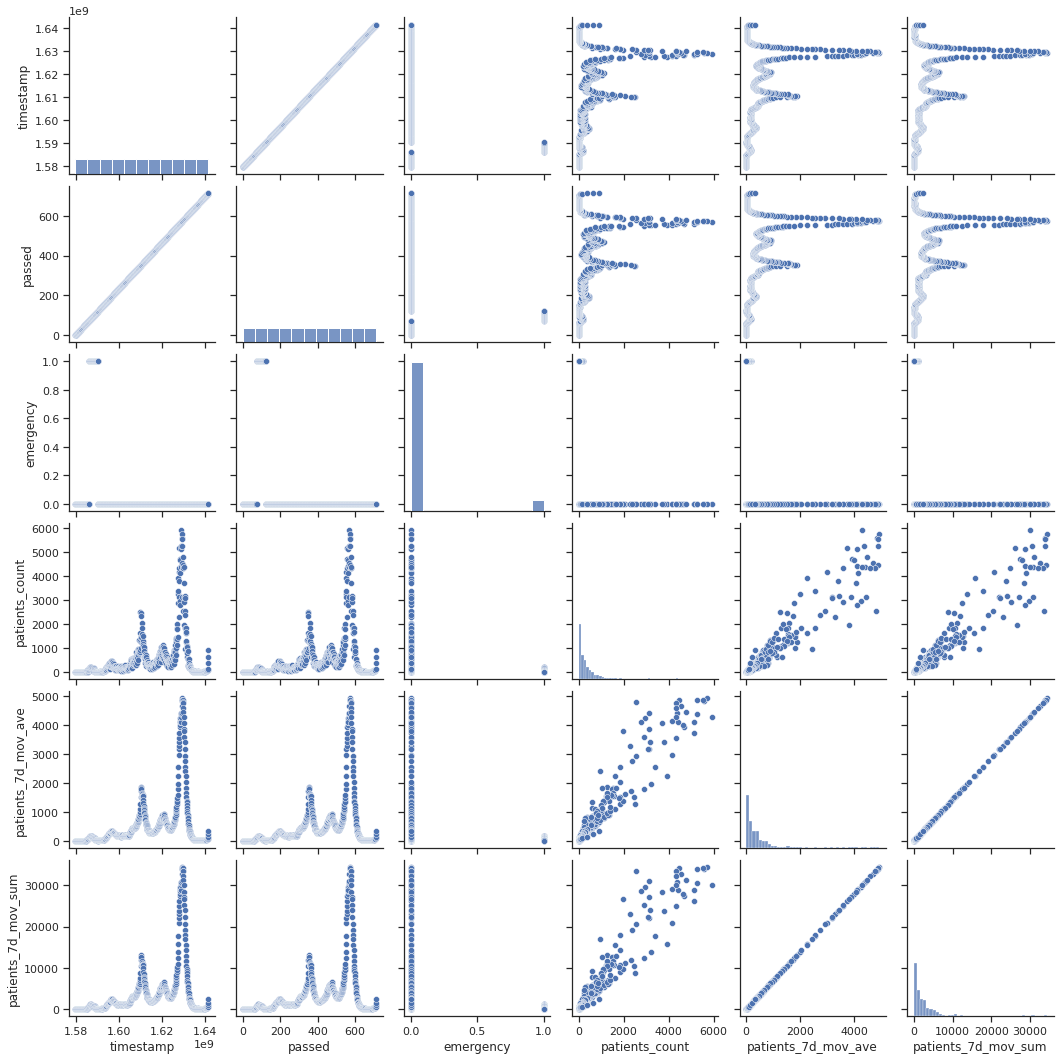

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
